# AI MoodSense - Model Training Notebook

This notebook trains a CNN model for emotion classification using FER2013 dataset.

## Steps:
1. Upload fer2013.csv to Colab/Kaggle
2. Run all cells to train the model
3. Download the trained model (moodsense_model.h5)


## 1. Install Required Libraries


In [1]:
# Install required packages
!pip install tensorflow pandas numpy scikit-learn opencv-python matplotlib seaborn


## 2. Import Libraries


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## 3. Load and Prepare Data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load FER2013 dataset
print("Loading FER2013 dataset...")
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GEARGEN/dataset/fer2013.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Extract pixels and emotions
pixels = df['pixels'].values
emotions = df['emotion'].values

# Convert pixel strings to numpy arrays
print("\nConverting pixel strings to images...")
images = []
for pixel_str in pixels:
    pixel_array = np.array([int(p) for p in pixel_str.split()], dtype=np.uint8)
    image = pixel_array.reshape(48, 48)
    images.append(image)

images = np.array(images, dtype=np.uint8)

print(f"\n✓ Loaded {len(images)} images")
print(f"✓ Image shape: {images.shape}")
print(f"✓ Memory usage: {images.nbytes / (1024**2):.2f} MB")


Loading FER2013 dataset...
Dataset shape: (35887, 3)
Columns: ['emotion', 'pixels', 'Usage']

Converting pixel strings to images...

✓ Loaded 35887 images
✓ Image shape: (35887, 48, 48)
✓ Memory usage: 78.85 MB


In [5]:
# Reduce emotion labels to 3 groups
# 0: Negative (angry, disgust, fear, sad)
# 1: Neutral (neutral)
# 2: Positive (happy, surprise)

original_to_reduced = {
    0: 0,  # angry -> Negative
    1: 0,  # disgust -> Negative
    2: 0,  # fear -> Negative
    3: 2,  # happy -> Positive
    4: 1,  # neutral -> Neutral
    5: 0,  # sad -> Negative
    6: 2   # surprise -> Positive
}

reduced_labels = np.array([original_to_reduced[e] for e in emotions])
label_names = ['Negative', 'Neutral', 'Positive']

print(f"Label distribution:")
unique, counts = np.unique(reduced_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label_names[label]}: {count} ({count/len(reduced_labels)*100:.1f}%)")


Label distribution:
  Negative: 14623 (40.7%)
  Neutral: 6077 (16.9%)
  Positive: 15187 (42.3%)


In [6]:
# Preprocess images: normalize to [0, 1] and add channel dimension
images = images.astype(np.float32) / 255.0
images = np.expand_dims(images, axis=-1)

print(f"Processed image shape: {images.shape}")


Processed image shape: (35887, 48, 48, 1)


In [7]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, reduced_labels,
    test_size=0.2,
    random_state=42,
    stratify=reduced_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Train: 25838 samples
Validation: 2871 samples
Test: 7178 samples


## 4. Build CNN Model


In [8]:
def create_model():
    """Create a simple CNN model for emotion classification"""
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer (3 classes)
        layers.Dense(3, activation='softmax')
    ])

    return model

model = create_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,395 (2.48 MB)

 Trainable params: 650,947 (2.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## 5. Train Model


In [10]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience to allow more training
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger('training_log.csv')  # Save training history
]

print(f"Training configuration:")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Validation samples: {X_val.shape[0]}")
print(f"  - Batch size: 64")
print(f"  - Max epochs: 50")
print(f"  - Early stopping patience: 15 epochs")
print(f"\nStarting training...\n")

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("Training completed!")
print("="*50)
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")


Training configuration:
  - Training samples: 25838
  - Validation samples: 2871
  - Batch size: 64
  - Max epochs: 50
  - Early stopping patience: 15 epochs

Starting training...

Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4287 - loss: 1.3929
Epoch 1: val_accuracy improved from -inf to 0.43504, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4288 - loss: 1.3923 - val_accuracy: 0.4350 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5316 - loss: 0.9621
Epoch 2: val_accuracy improved from 0.43504 to 0.58621, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5316 - loss: 0.9621 - val_accuracy: 0.5862 - val_loss: 0.9334 - learning_rate: 0.0010
Epoch 3/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5794 - loss: 0.9011
Epoch 3: val_accuracy improved from 0.58621 to 0.58760, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5796 - loss: 0.9009 - val_accuracy: 0.5876 - val_loss: 0.8657 - learning_rate: 0.0010
Epoch 4/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6039 - loss: 0.8610
Epoch 4: val_accuracy improved from 0.58760 to 0.59108, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6039 - loss: 0.8609 - val_accuracy: 0.5911 - val_loss: 0.8490 - learning_rate: 0.0010
Epoch 5/50
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6206 - loss: 0.8333
Epoch 5: val_accuracy improved from 0.59108 to 0.59491, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6206 - loss: 0.8332 - val_accuracy: 0.5949 - val_loss: 0.8578 - learning_rate: 0.0010
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6319 - loss: 0.8085
Epoch 6: val_accuracy improved from 0.59491 to 0.64054, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6319 - loss: 0.8085 - val_accuracy: 0.6405 - val_loss: 0.8045 - learning_rate: 0.0010
Epoch 7/50
396/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6435 - loss: 0.7836
Epoch 7: val_accuracy did not improve from 0.64054
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6435 - loss: 0.7837 - val_accuracy: 0.6102 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 8/50
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6593 - loss: 0.7653
Epoch 8: val_accuracy improved from 0.64054 to 0.65761, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6593 - loss: 0.7653 - val_accuracy: 0.6576 - val_loss: 0.7835 - learning_rate: 0.0010
Epoch 9/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6682 - loss: 0.7478
Epoch 9: val_accuracy improved from 0.65761 to 0.66423, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6682 - loss: 0.7479 - val_accuracy: 0.6642 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 10/50
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6696 - loss: 0.7358
Epoch 10: val_accuracy did not improve from 0.66423
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6696 - loss: 0.7358 - val_accuracy: 0.6454 - val_loss: 0.7733 - learning_rate: 0.0010
Epoch 11/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6883 - loss: 0.7099
Epoch 11: val_accuracy improved from 0.66423 to 0.66736, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6882 - loss: 0.7099 - val_accuracy: 0.6674 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 12/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6896 - loss: 0.7011
Epoch 12: val_accuracy improved from 0.66736 to 0.68304, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6896 - loss: 0.7011 - val_accuracy: 0.6830 - val_loss: 0.7174 - learning_rate: 0.0010
Epoch 13/50
401/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7003 - loss: 0.6821
Epoch 13: val_accuracy did not improve from 0.68304
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7003 - loss: 0.6822 - val_accuracy: 0.6809 - val_loss: 0.7336 - learning_rate: 0.0010
Epoch 14/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7041 - loss: 0.6642
Epoch 14: val_accuracy improved from 0.68304 to 0.68339, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7040 - loss: 0.6643 - val_accuracy: 0.6834 - val_loss: 0.7149 - learning_rate: 0.0010
Epoch 15/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7115 - loss: 0.6546
Epoch 15: val_accuracy did not improve from 0.68339
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7115 - loss: 0.6547 - val_accuracy: 0.6583 - val_loss: 0.7601 - learning_rate: 0.0010
Epoch 16/50
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7191 - loss: 0.6387
Epoch 16: val_accuracy improved from 0.68339 to 0.68861, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7191 - loss: 0.6388 - val_accuracy: 0.6886 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 17/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7293 - loss: 0.6312
Epoch 17: val_accuracy improved from 0.68861 to 0.70150, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7292 - loss: 0.6313 - val_accuracy: 0.7015 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 18/50
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7442 - loss: 0.6018
Epoch 18: val_accuracy improved from 0.70150 to 0.70289, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7441 - loss: 0.6018 - val_accuracy: 0.7029 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 19/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7495 - loss: 0.5887
Epoch 19: val_accuracy did not improve from 0.70289
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7494 - loss: 0.5889 - val_accuracy: 0.6998 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 20/50
399/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7550 - loss: 0.5812
Epoch 20: val_accuracy did not improve from 0.70289
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7549 - loss: 0.5814 - val_accuracy: 0.6879 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 21/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7554 - loss: 0.5719
Epoch 21: val_accuracy improved from 0.70289 to 0.70428, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7553 - loss: 0.5720 - val_accuracy: 0.7043 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 22/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7604 - loss: 0.5621
Epoch 22: val_accuracy did not improve from 0.70428
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7603 - loss: 0.5623 - val_accuracy: 0.6712 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 23/50
397/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7724 - loss: 0.5482
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: val_accuracy did not improve from 0.70428
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7723 - loss: 0.5483 - val_accuracy: 0.6858 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 24/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7854 - loss: 0.5136
Epoch 24: val_accuracy improved from 0.70428 to 0.70846, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7854 - loss: 0.5136 - val_accuracy: 0.7085 - val_loss: 0.6840 - learning_rate: 5.0000e-04
Epoch 25/50
399/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7930 - loss: 0.4899
Epoch 25: val_accuracy improved from 0.70846 to 0.71439, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7930 - loss: 0.4900 - val_accuracy: 0.7144 - val_loss: 0.6657 - learning_rate: 5.0000e-04
Epoch 26/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8034 - loss: 0.4809
Epoch 26: val_accuracy did not improve from 0.71439
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8034 - loss: 0.4809 - val_accuracy: 0.7050 - val_loss: 0.7256 - learning_rate: 5.0000e-04
Epoch 27/50
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8092 - loss: 0.4644
Epoch 27: val_accuracy improved from 0.71439 to 0.71996, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8091 - loss: 0.4645 - val_accuracy: 0.7200 - val_loss: 0.6683 - learning_rate: 5.0000e-04
Epoch 28/50
397/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8134 - loss: 0.4598
Epoch 28: val_accuracy did not improve from 0.71996
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8134 - loss: 0.4598 - val_accuracy: 0.7113 - val_loss: 0.6903 - learning_rate: 5.0000e-04
Epoch 29/50
399/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8178 - loss: 0.4456
Epoch 29: val_accuracy did not improve from 0.71996
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8177 - loss: 0.4457 - val_accuracy: 0.7140 - val_loss: 0.6891 - learning_rate: 5.0000e-04
Epoch 30/50
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8222 - loss: 0.4331
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: val_accuracy did not improve from 0.71996
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8221 - loss: 0.

404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8271 - loss: 0.4245 - val_accuracy: 0.7214 - val_loss: 0.6929 - learning_rate: 2.5000e-04
Epoch 32/50
397/404 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8257 - loss: 0.4178
Epoch 32: val_accuracy did not improve from 0.72135
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8258 - loss: 0.4177 - val_accuracy: 0.7214 - val_loss: 0.6973 - learning_rate: 2.5000e-04
Epoch 33/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8409 - loss: 0.3956
Epoch 33: val_accuracy improved from 0.72135 to 0.72344, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8408 - loss: 0.3957 - val_accuracy: 0.7234 - val_loss: 0.6891 - learning_rate: 2.5000e-04
Epoch 34/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.3893
Epoch 34: val_accuracy did not improve from 0.72344
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8448 - loss: 0.3893 - val_accuracy: 0.7203 - val_loss: 0.6942 - learning_rate: 2.5000e-04
Epoch 35/50
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8420 - loss: 0.3956
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 35: val_accuracy did not improve from 0.72344
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8420 - loss: 0.3956 - val_accuracy: 0.7200 - val_loss: 0.7040 - learning_rate: 2.5000e-04
Epoch 36/50
397/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - loss: 0.3830
Epoch 36: val_accuracy did not improve from 0.72344
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8474 - loss: 0.

404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8505 - loss: 0.3735 - val_accuracy: 0.7241 - val_loss: 0.7069 - learning_rate: 1.2500e-04
Epoch 39/50
398/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8561 - loss: 0.3660
Epoch 39: val_accuracy improved from 0.72414 to 0.72762, saving model to best_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8560 - loss: 0.3661 - val_accuracy: 0.7276 - val_loss: 0.7001 - learning_rate: 1.2500e-04
Epoch 40/50
400/404 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8546 - loss: 0.3662
Epoch 40: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 40: val_accuracy did not improve from 0.72762
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8546 - loss: 0.3662 - val_accuracy: 0.7245 - val_loss: 0.7071 - learning_rate: 1.2500e-04
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 25.

Training completed!
Total epochs trained: 40
Best validation accuracy: 0.7276
Best validation loss: 0.6657


## 5.1. Check Training Status

Run this cell to see why training stopped and verify the model state.


In [11]:
# Check if early stopping triggered
print("Training Summary:")
print(f"  Total epochs completed: {len(history.history['loss'])}")
print(f"  Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Best epoch: {np.argmax(history.history['val_accuracy']) + 1}")

# Check if training stopped early
if len(history.history['loss']) < 50:
    print(f"\n⚠️  Training stopped early at epoch {len(history.history['loss'])}")
    print("   This is normal if EarlyStopping callback triggered.")
    print("   The best model weights have been restored automatically.")
else:
    print(f"\n✓ Training completed all 50 epochs")


Training Summary:
  Total epochs completed: 40
  Final training accuracy: 0.8545
  Final validation accuracy: 0.7245
  Best validation accuracy: 0.7276
  Best epoch: 39

⚠️  Training stopped early at epoch 40
   This is normal if EarlyStopping callback triggered.
   The best model weights have been restored automatically.


## 6. Evaluate Model


In [12]:
# Load best model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 71.19%
Test Loss: 0.7372


In [13]:
# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_names))


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.73      0.74      2925
     Neutral       0.52      0.40      0.45      1215
    Positive       0.73      0.82      0.77      3038

    accuracy                           0.71      7178
   macro avg       0.67      0.65      0.66      7178
weighted avg       0.70      0.71      0.71      7178



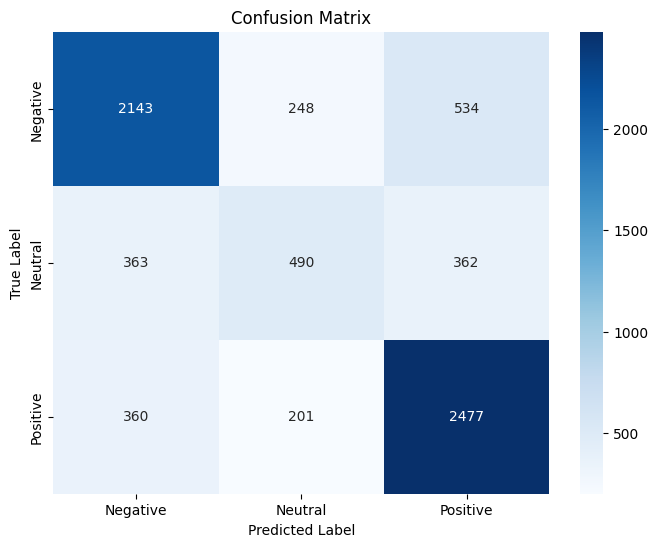

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


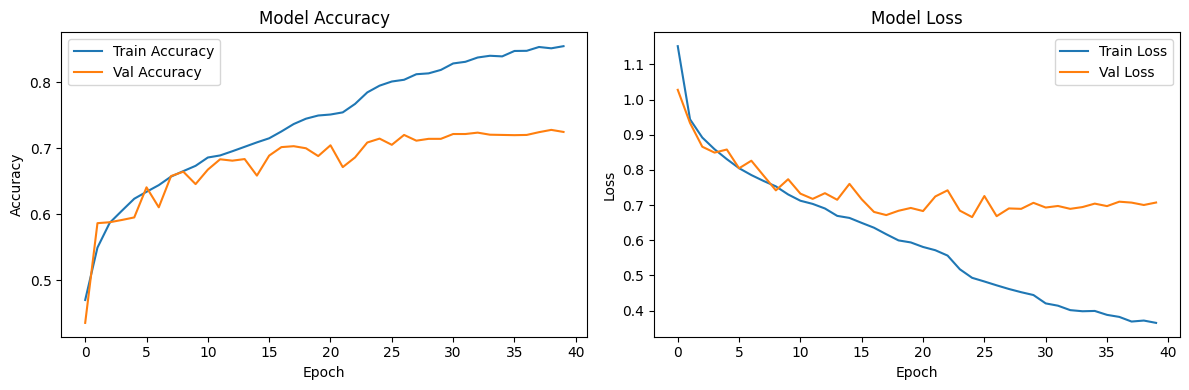

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 7. Save Model


In [16]:
# Save final model
model.save('moodsense_model.h5')
print("Model saved as 'moodsense_model.h5'")
print("\nPlease download this file and place it in the 'models' folder of your project.")


Model saved as 'moodsense_model.h5'

Please download this file and place it in the 'models' folder of your project.
